# Prediction of sales

### Problem Statement
This dataset represents sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store are available. The aim is to build a predictive model and find out the sales of each product at a particular store.

Please note that the data may have missing values as some stores might not report all the data due to technical glitches. Hence, it will be required to treat them accordingly.

---------------------

### Explore the problem in following stages:

1. Hypothesis Generation – understanding the problem better by brainstorming possible factors that can impact the outcome
2. Data Exploration – looking at categorical and continuous feature summaries and making inferences about the data.
3. Data Cleaning – imputing missing values in the data and checking for outliers
4. Feature Engineering – modifying existing variables and creating new ones for analysis
5. Model Building – making predictive models on the data

In [496]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path

%matplotlib inline

# data csv loations
data_path = './data'

In [497]:
df_sales = pd.read_csv(Path(data_path) / 'store_sales.csv')
df_sales.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


### 1. Hypothesis Generation

The target variable is `Item_Outlet_Sales`.

|Variable|Description|
| ------------- |-------------|
|Item_Identifier|Unique product ID|
|Item_Weight|Weight of product|
|Item_Fat_Content|Whether the product is low fat or not|
|Item_Visibility|The % of total display area of all products in a store allocated to the particular product|
|Item_Type|The category to which the product belongs|
|Item_MRP|Maximum Retail Price (list price) of the product|
|Outlet_Identifier|Unique store ID|
|Outlet_Establishment_Year|The year in which store was established|
|Outlet_Size|The size of the store in terms of ground area covered|
|Outlet_Location_Type|The type of city in which the store is located|
|Outlet_Type|Whether the outlet is just a grocery store or some sort of supermarket|
|Item_Outlet_Sales|Sales of the product in the particulat store. This is the outcome variable to be predicted.|

Let's differentiate between `categorical` and `numerical` features:

##### Data Types

In [498]:
df_sales_cat = df_sales[[
    'Item_Identifier',
    'Item_Fat_Content',
    'Item_Type',
    'Outlet_Identifier',
    'Outlet_Establishment_Year',
    'Outlet_Size',
    'Outlet_Location_Type',
    'Outlet_Type']]
df_sales_cat.head()

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDA15,Low Fat,Dairy,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,DRC01,Regular,Soft Drinks,OUT018,2009,Medium,Tier 3,Supermarket Type2
2,FDN15,Low Fat,Meat,OUT049,1999,Medium,Tier 1,Supermarket Type1
3,FDX07,Regular,Fruits and Vegetables,OUT010,1998,NaN,Tier 3,Grocery Store
4,NCD19,Low Fat,Household,OUT013,1987,High,Tier 3,Supermarket Type1


In [499]:
df_sales_num = df_sales.drop(columns=df_sales_cat.columns)
df_sales_num.head()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales
0,9.30,0.016047,249.8092,3735.1380
1,5.92,0.019278,48.2692,443.4228
2,17.50,0.016760,141.6180,2097.2700
3,19.20,0.000000,182.0950,732.3800
4,8.93,0.000000,53.8614,994.7052


**Which features seem intuitive to drop? Which are correlated with the other?**

Consumer sentiment regarding fat content of products may contribute to the product sales.
- check `Item_Fat_Content` and decide whether or not it is ordinal

The `Item_Type` will most certainly affect how much of it sold and by how much.
- check if the `Item_Identifier` offers the same kind of information and remove appropriately
- `Item_MRP` may be folded into an average of the type of item priced
- the combination helps with high cardinality and reduces features

What affect does `Item_Weight` have on its overall sales?
How about `Item_Visibility`?

`Outlet` data has overlapping information.
- `Outlet_Identifier`, `Outlet_Type`, and `Outlet_Location_Type` may describe the same information
- The `Outlet_Identifier` in particular does not intuitively impart meaningful information

Seems intuitive to ordinally encode `Outlet_Establishment_Year` and `Outlet_Location_Type` if the following are true:
- **newer** is better
- **larger** is batter

### 2. Exploratory Data Analysis

In [500]:
print(df_sales.shape)
print(df_sales.dtypes)

(8523, 12)
Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object


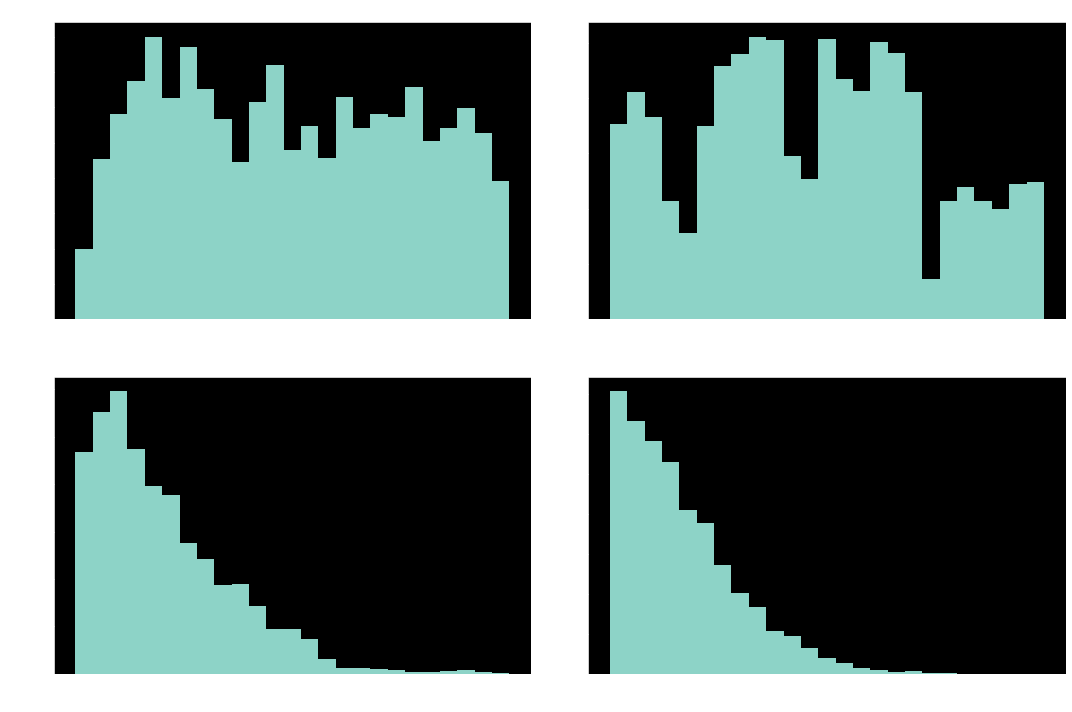

In [501]:
fig, ax = plt.subplots(2, 2, figsize=(15,10))

ax[0,0].set_title('Item Weight Distribution')
ax[0,0].set_xlabel('type')
ax[0,0].set_ylabel('count')
ax[0,0].hist(df_sales['Item_Weight'], bins=25)

ax[0,1].set_title('Item MRP Distribution')
ax[0,1].set_xlabel('max MRP')
ax[0,1].set_ylabel('count')
ax[0,1].hist(df_sales['Item_MRP'], bins=25)

ax[1,0].set_title('Item Visibility')
ax[1,0].set_xlabel('visibility')
ax[1,0].set_ylabel('count')
ax[1,0].hist(df_sales['Item_Visibility'], bins=25)

ax[1,1].set_title('Item Sales')
ax[1,1].set_xlabel('sales')
ax[1,1].set_ylabel('count')
ax[1,1].hist(df_sales['Item_Outlet_Sales'], bins=25)

plt.tight_layout()
plt.show()

##### Relationships

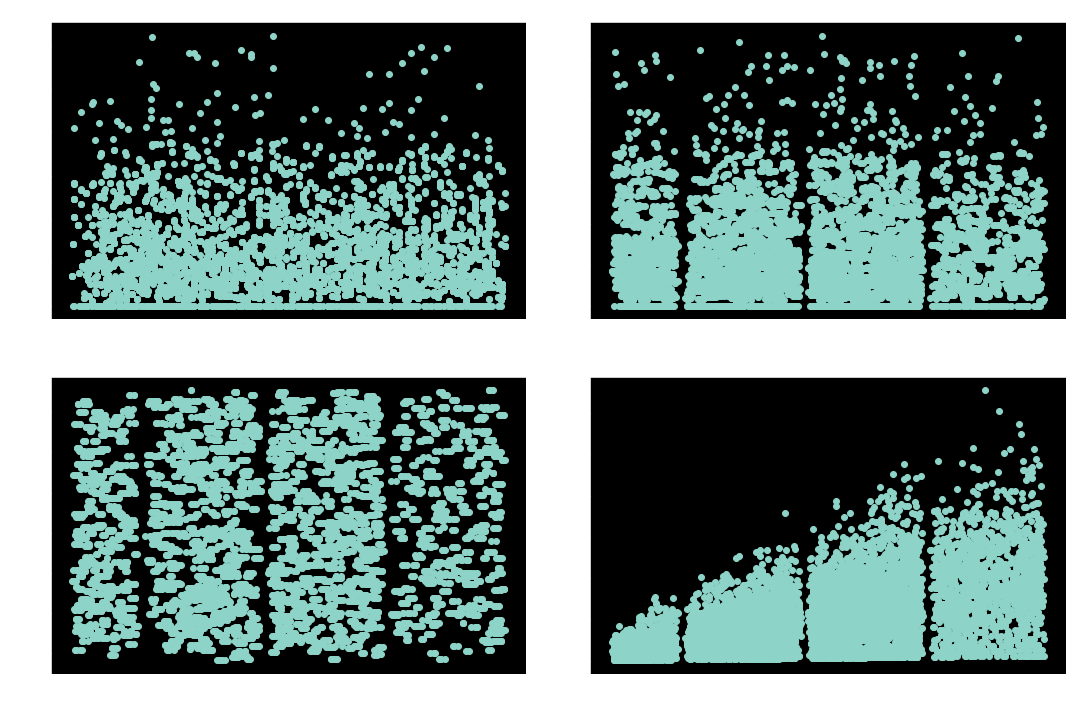

In [502]:
fig, ax = plt.subplots(2, 2, figsize=(15,10))

ax[0,0].set_title('Visibility of Item based On Weight')
ax[0,0].set_xlabel('weight')
ax[0,0].set_ylabel('visibility')
ax[0,0].scatter(df_sales['Item_Weight'], df_sales['Item_Visibility'])

ax[0,1].set_title('Visibility of Item based on Price')
ax[0,1].set_xlabel('max MRP')
ax[0,1].set_ylabel('visibility')
ax[0,1].scatter(df_sales['Item_MRP'], df_sales['Item_Visibility'])

ax[1,0].set_title('MRP of Item based on Weight')
ax[1,0].set_xlabel('max MRP')
ax[1,0].set_ylabel('weight')
ax[1,0].scatter(df_sales['Item_MRP'], df_sales['Item_Weight'])

ax[1,1].set_title('Item Sales vs MRP')
ax[1,1].set_ylabel('sales')
ax[1,1].set_xlabel('max MRP')
ax[1,1].scatter(df_sales['Item_MRP'], df_sales['Item_Outlet_Sales'])

plt.tight_layout()
plt.show()

##### Missing Values

In [503]:
print('Missing item_weights:', df_sales.isnull().sum()['Item_Weight']/df_sales.shape[0] * 100, '%')
print('Missing outlet_size:', df_sales.isnull().sum()['Outlet_Size']/df_sales.shape[0] * 100, '%')

Missing item_weights: 17.165317376510618 %
Missing outlet_size: 28.27642848762173 %


- Replace the weights with the average of the items they represent.
- Drop the `Outlet_Size` columns because it is missing too many values, and there is no obvious way of assigning reasonable values to it.

In [504]:
# determine average weights by item type
df_avg_weights = df_sales[['Item_Type', 'Item_Weight']].groupby('Item_Type').aggregate('mean').reset_index()
df_avg_weights

,Item_Type,Item_Weight
0,Baking Goods,12.277108
1,Breads,11.346936
2,Breakfast,12.768202
3,Canned,12.305705
4,Dairy,13.426069
5,Frozen Foods,12.867061
6,Fruits and Vegetables,13.224769
7,Hard Drinks,11.400328
8,Health and Hygiene,13.142314
9,Household,13.384736


In [505]:
# isolate rows where item weight is null
df_null_weights = df_sales[df_sales['Item_Weight'].isnull()]
df_null_weights.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
18,DRI11,NaN,Low Fat,0.034238,Hard Drinks,113.2834,OUT027,1985,Medium,Tier 3,Supermarket Type3,2303.6680
21,FDW12,NaN,Regular,0.035400,Baking Goods,144.5444,OUT027,1985,Medium,Tier 3,Supermarket Type3,4064.0432
23,FDC37,NaN,Low Fat,0.057557,Baking Goods,107.6938,OUT019,1985,Small,Tier 1,Grocery Store,214.3876
29,FDC14,NaN,Regular,0.072222,Canned,43.6454,OUT019,1985,Small,Tier 1,Grocery Store,125.8362


In [506]:
# replace null row weights with average values by type
df_weights = pd.merge(df_null_weights, df_avg_weights, how='left', on=['Item_Type'], )
df_weights.drop(columns=['Item_Weight_x'], inplace=True)
df_weights.rename(columns={'Item_Weight_y' : 'Item_Weight'}, inplace=True)

# rearrange columns
cols = df_weights.columns.to_list()
df_weights = df_weights[[
    'Item_Identifier',
    'Item_Weight',
    'Item_Fat_Content',
    'Item_Visibility',
    'Item_Type',
    'Item_MRP',
    'Outlet_Identifier',
    'Outlet_Establishment_Year',
    'Outlet_Size',
    'Outlet_Location_Type',
    'Outlet_Type',
    'Item_Outlet_Sales',
    ]]

# drop rows with null weights, then concatenate new rows with average values and reset index
print(df_sales.shape[0], df_weights.shape[0])
df_sales = df_sales[~(df_sales['Item_Weight'].isnull())]
print(df_sales.shape[0])
df_sales = pd.concat([df_sales, df_weights], axis=0)
print(df_sales.shape[0])
df_sales.reset_index(inplace=True, drop=True)

# drop outlet size feature
df_sales.drop(columns=['Outlet_Size'], inplace=True)

8523 1463
7060
8523


In [507]:
df_sales.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

##### Zero Values

In [508]:
df_sales[df_sales['Item_Visibility'] == 0]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
3,FDX07,19.200000,Regular,0.0,Fruits and Vegetables,182.0950,OUT010,1998,Tier 3,Grocery Store,732.3800
4,NCD19,8.930000,Low Fat,0.0,Household,53.8614,OUT013,1987,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395000,Regular,0.0,Baking Goods,51.4008,OUT018,2009,Tier 3,Supermarket Type2,556.6088
9,FDY07,11.800000,Low Fat,0.0,Fruits and Vegetables,45.5402,OUT049,1999,Tier 1,Supermarket Type1,1516.0266
27,FDP33,18.700000,Low Fat,0.0,Snack Foods,256.6672,OUT018,2009,Tier 3,Supermarket Type2,3068.0064
...,...,...,...,...,...,...,...,...,...,...,...
8488,FDT24,12.277108,Regular,0.0,Baking Goods,75.9328,OUT027,1985,Tier 3,Supermarket Type3,3012.0792
8491,FDX31,13.224769,Regular,0.0,Fruits and Vegetables,234.7958,OUT019,1985,Tier 1,Grocery Store,467.3916
8505,DRH39,13.426069,low fat,0.0,Dairy,75.9670,OUT019,1985,Tier 1,Grocery Store,153.1340
8508,FDT48,12.277108,Low Fat,0.0,Baking Goods,196.5084,OUT027,1985,Tier 3,Supermarket Type3,793.6336


Zero visibility items could represent items not sold in store or items that represent a small space of the store such that it appears to be zero as a rounding error.

### 2. Clean Data

In [509]:
for col in df_sales_cat.columns:
    print(col, df_sales_cat[col].unique())

Item_Identifier ['FDA15' 'DRC01' 'FDN15' ... 'NCF55' 'NCW30' 'NCW05']
Item_Fat_Content ['Low Fat' 'Regular' 'low fat' 'LF' 'reg']
Item_Type ['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']
Outlet_Identifier ['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']
Outlet_Establishment_Year [1999 2009 1998 1987 1985 2002 2007 1997 2004]
Outlet_Size ['Medium' nan 'High' 'Small']
Outlet_Location_Type ['Tier 1' 'Tier 3' 'Tier 2']
Outlet_Type ['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']


In [510]:
# clean item fat feature
for i, value in enumerate(df_sales['Item_Fat_Content']):
    
    try:
        if value in ['LF', 'low fat']:
            df_sales.loc[i, 'Item_Fat_Content'] = 'Low Fat'
        if value in ['reg']:
            df_sales.loc[i, 'Item_Fat_Content'] = 'Regular'
    except IndexError:
        break

In [511]:
df_sales['Item_Fat_Content'].sort_values().value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

##### Outliers

Measure outliers by std > 3.

In [512]:
df_sales[['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Item_Outlet_Sales']].describe()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857890,0.066132,140.992782,2181.288914
std,4.232804,0.051598,62.275067,1706.499616
min,4.555000,0.000000,31.290000,33.290000
25%,9.310000,0.026989,93.826500,834.247400
50%,12.867061,0.053931,143.012800,1794.331000
75%,16.000000,0.094585,185.643700,3101.296400
max,21.350000,0.328391,266.888400,13086.964800


In [513]:
# caluclations for mean and standard deviation for the sales records
sales_std = df_sales['Item_Outlet_Sales'].std()
sales_mean = df_sales['Item_Outlet_Sales'].mean()

# if the item is less that 3 stadard deviations from the mean, mark it
for i, item in enumerate(df_sales['Item_Outlet_Sales']):
    
    if abs(sales_mean - item)/sales_std < 3:
        df_sales.loc[i, 'Outlier'] = 1
    else:
        0
        
df_sales = df_sales[df_sales['Outlier'] == 1].drop(columns=['Outlier'])

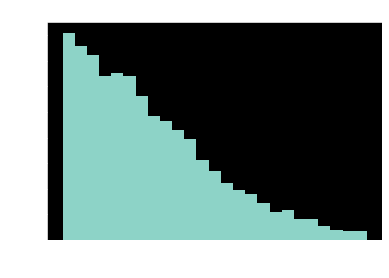

<Figure size 864x576 with 0 Axes>

In [514]:
fig,ax = plt.subplots()
fig = plt.figure(figsize=(12, 8))

ax.set_title('Outlet Sales per Itme')
ax.set_xlabel('Sales')
ax.set_ylabel('Count')
ax.hist(df_sales['Item_Outlet_Sales'], bins=25)

fig.tight_layout()
plt.show()


### 3. Feature Engineering

##### Ratio of Item MRP / Average MRP of each type of item

In [515]:
# get the mean MRP for each item
df_avg_mrp = df_sales[['Item_Type', 'Item_MRP']].groupby('Item_Type').aggregate('mean')
df_avg_mrp.reset_index(inplace=True)

# merge average MRP table on item type to assign the average to each item type
df_sales = pd.merge(df_sales, df_avg_mrp.rename(columns={'Item_MRP' : 'Item_MRP_Avg'}), how='left', on=['Item_Type'])
df_sales = df_sales[[
    'Item_Identifier',
    'Item_Weight',
    'Item_Fat_Content',
    'Item_Visibility',
    'Item_Type',
    'Item_MRP',
    'Item_MRP_Avg',
    'Outlet_Identifier',
    'Outlet_Establishment_Year',
    'Outlet_Location_Type',
    'Outlet_Type',
    'Item_Outlet_Sales'
    ]]

# replace item_identifier with the ratio of its price to the average price of the category it belongs to
for i in range(df_sales.shape[0]):
    df_sales.loc[i, 'Item_Identifier'] = df_sales.loc[i, 'Item_MRP'] / df_sales.loc[i, 'Item_MRP_Avg']

# drop Item_MRP, Item_MRP_Avg, Item_Type, and rename Item_Identifier
df_sales.rename(columns={'Item_Identifier' :'Item_AvgPrice_Index'}, inplace=True)
df_sales['Item_AvgPrice_Index'] = df_sales['Item_AvgPrice_Index'].astype(float)
df_sales = df_sales[[
    'Item_AvgPrice_Index',
    'Item_Weight',
    'Item_Fat_Content',
    'Item_Visibility',
    'Outlet_Identifier',
    'Outlet_Establishment_Year',
    'Outlet_Location_Type',
    'Outlet_Type',
    'Item_Outlet_Sales'
    ]]

In [516]:
df_sales

,Item_AvgPrice_Index,Item_Weight,Item_Fat_Content,Item_Visibility,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,1.707644,9.300000,Low Fat,0.016047,OUT049,1999,Tier 1,Supermarket Type1,3735.1380
1,0.369688,5.920000,Regular,0.019278,OUT018,2009,Tier 3,Supermarket Type2,443.4228
2,1.016647,17.500000,Low Fat,0.016760,OUT049,1999,Tier 1,Supermarket Type1,2097.2700
3,1.270234,19.200000,Regular,0.000000,OUT010,1998,Tier 3,Grocery Store,732.3800
4,0.361648,8.930000,Low Fat,0.000000,OUT013,1987,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...
8428,1.447932,11.847460,Low Fat,0.043792,OUT027,1985,Tier 3,Supermarket Type3,6261.8490
8429,1.261819,11.847460,Low Fat,0.037006,OUT027,1985,Tier 3,Supermarket Type3,4111.3150
8430,1.389980,13.853285,Low Fat,0.091473,OUT027,1985,Tier 3,Supermarket Type3,2756.4120
8431,1.132536,13.224769,Regular,0.102296,OUT019,1985,Tier 1,Grocery Store,487.3656


##### Converting age to 1980, 1990, and 2000s

In [517]:
sorted(df_sales['Outlet_Establishment_Year'].unique())

[1985, 1987, 1997, 1998, 1999, 2002, 2004, 2007, 2009]

In [518]:
# sort the years into decades
df_years = pd.get_dummies(df_sales['Outlet_Establishment_Year'])
df_1980 = df_years[1985] + df_years[1987]
df_1990 = df_years[1997] + df_years[1998] + df_years[1999]
df_2000 = df_years[2002] + df_years[2004] + df_years[2007] + df_years[2009]

# concatenate dataframes and rename the columns
df_sales = pd.concat([df_sales, df_1980, df_1990, df_2000], axis=1)
df_sales.rename(columns={0:1980, 1:1990, 2:2000}, inplace=True)
df_sales.drop(columns=['Outlet_Establishment_Year'], inplace=True)

##### Hot-Encoding

In [519]:
# instantiate OneHotEncoding
ohe = OneHotEncoder(drop='if_binary', dtype='int')

# fit and transform Item_Fat_Content
df_sales['Item_Fat_Content'] = ohe.fit_transform(df_sales['Item_Fat_Content'].array.reshape(-1,1)).toarray()

##### Dummies

In [520]:
df_sales['Outlet_Location_Type'].value_counts()

Tier 3    3285
Tier 2    2768
Tier 1    2380
Name: Outlet_Location_Type, dtype: int64

In [521]:
# generate dummies for everything else
df_sales.drop(columns=['Outlet_Identifier'], inplace=True)
df_sales = pd.get_dummies(df_sales)

##### Scale the Data

In [522]:
# instantiate a MinMax object
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_sales)

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


##### Feature Reduction

In [523]:
pd.DataFrame(df_scaled, columns=df_sales.columns)

,Item_AvgPrice_Index,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Outlet_Sales,1980,1990,2000,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,0.787796,0.282525,0.0,0.048866,0.509531,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.080257,0.081274,1.0,0.058705,0.056452,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.422382,0.770765,0.0,0.051037,0.284091,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.556484,0.871986,1.0,0.000000,0.096224,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,0.076005,0.260494,0.0,0.000000,0.132331,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8428,0.650455,0.434204,0.0,0.133352,0.857313,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
8429,0.552034,0.434204,0.0,0.112689,0.561309,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
8430,0.619808,0.553634,0.0,0.278548,0.374817,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
8431,0.483667,0.516211,1.0,0.311506,0.062500,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [524]:
abs(df_sales.corr()['Item_Outlet_Sales']).sort_values()

Item_Weight                      0.011548
Item_Fat_Content                 0.020195
Outlet_Location_Type_Tier 3      0.020767
Outlet_Type_Supermarket Type2    0.026395
1980                             0.049235
2000                             0.055716
Outlet_Location_Type_Tier 2      0.076463
Outlet_Location_Type_Tier 1      0.102274
1990                             0.109963
Item_Visibility                  0.131656
Outlet_Type_Supermarket Type1    0.148798
Outlet_Type_Supermarket Type3    0.267743
Outlet_Type_Grocery Store        0.430371
Item_AvgPrice_Index              0.560434
Item_Outlet_Sales                1.000000
Name: Item_Outlet_Sales, dtype: float64

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


array([1.62084080e+03, 1.61723787e+03, 1.61744535e+03, ...,
       1.77665546e-09, 1.77665548e-09, 1.77665562e-09])

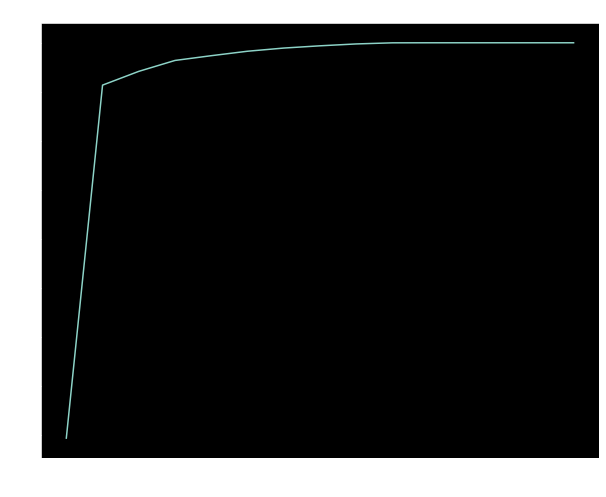

In [525]:
# fit/transform PCA and plot cumulative variance for feature importance
# pca_sales = df_sales.drop(columns=['Item_Outlet_Sales'])

pca = PCA()
pca.fit(df_sales)
pca_sales = pca.transform(df_sales)

# plot
fig,ax = plt.subplots(figsize=(10,8))
ax.set_title('PCA Feature Importance')
ax.set_xlabel('PCA n_component')
ax.set_ylabel('% cumulative variance')
ax.plot(range(1, pca.n_components_ + 1), np.cumsum((pca.explained_variance_ratio_)))
# ax.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_)

np.cumsum(pca_sales)

/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
<ipython-input-529-306f99ef12d2>:7: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


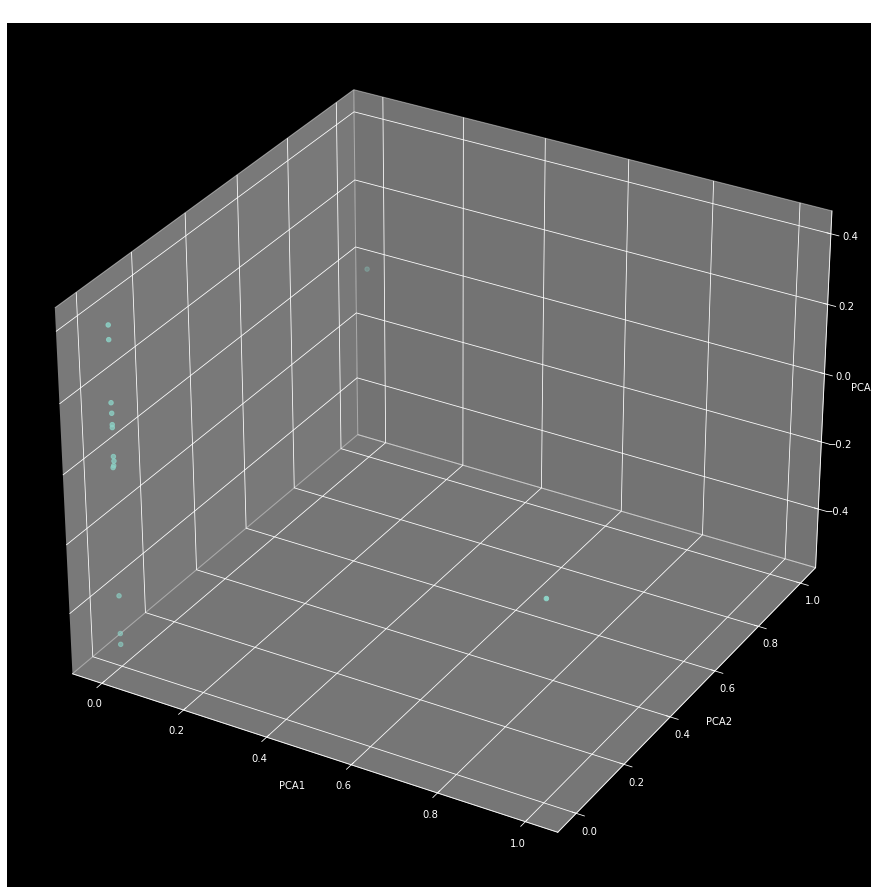

PCA score: -17.280334859766935
PCA components: [[ 1.55801787e-04  3.09839683e-05  6.09662937e-06 -4.30155691e-06
   9.99999979e-01  1.39106415e-05 -3.13777179e-05  1.74670765e-05
  -2.90845804e-05  2.26860481e-05  6.39853227e-06 -9.09752408e-05
   4.46063273e-05 -5.21897169e-06  5.15878853e-05]
 [ 1.27159580e-03  9.99990953e-01 -2.56437538e-03 -1.16567250e-04
  -3.09748072e-05  8.97691849e-04  7.53787254e-04 -1.65147910e-03
   5.98446781e-04 -1.78155945e-03  1.18311267e-03  6.86882977e-04
  -5.31555600e-04  1.30080349e-04 -2.85407727e-04]
 [ 1.85668192e-02 -2.92444881e-03  2.23988158e-03  6.21425747e-03
   3.78850718e-05  3.57814034e-01  1.21530819e-01 -4.79344852e-01
   1.13289544e-01 -5.11275726e-01  3.97986182e-01  1.53477294e-01
  -3.68962686e-01  3.19308735e-02  1.83554518e-01]]


/opt/homebrew/Caskroom/miniforge/base/envs/lighthouse/lib/python3.8/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


(3, 15)

In [529]:
# plotting the cumulative variance of the features allows for a reduction in features
pca = PCA(n_components=3)
pca_sales = pca.fit_transform(df_sales)

# plot 2d representation of the features
fig = plt.figure(figsize=(15,12))
ax = Axes3D(fig)
ax.set_title('PCA Features')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.scatter(pca.components_[0], pca.components_[1], pca.components_[2])

plt.show()

print('PCA score:', pca.score(df_sales))
print('PCA components:', pca.components_)

pca.components_.shape

We have covered how to prepare a dataset and the process of feature engineering two weeks ago. In addition, we have already created Lasso and Ridge regressions on Monday. Today, we will be working with the ensemble methods. 

-------------------------
### Model Building: Ensemble Models

Try out the different ensemble models (Random Forest Regressor, Gradient Boosting, XGBoost)
- **Note:** Spend some time on the documention for each of these models.
- **Note:** As you spend time on this challenge, it is suggested to review how each of these models work and how they compare to each other.

Calculate the **mean squared error** on the test set. Explore how different parameters of the model affect the results and the performance of the model. (*Stretch: Create a visualization to display this information*)

- Use GridSearchCV to find optimal paramaters of models.
- Compare agains the Lasso and Ridge Regression models from Monday.

**Questions to answer:**
- Which ensemble model performed the best? 